<a href="https://colab.research.google.com/github/tzyc910/Sythetic-Data-Model/blob/main/Synthetic_Data_Model_Performance_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Environment Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Mount your google drive to this google colab

In [ ]:
!unzip /content/drive/MyDrive/xray_images.zip

Archive:  /content/drive/MyDrive/xray_images.zip
   creating: xray_images/
   creating: xray_images/atelectasis/
  inflating: xray_images/atelectasis/00000011_006.png  
  inflating: xray_images/atelectasis/00000030_000.png  
  inflating: xray_images/atelectasis/00000030_001.png  
  inflating: xray_images/atelectasis/00000047_004.png  
  inflating: xray_images/atelectasis/00000060_000.png  
  inflating: xray_images/atelectasis/00000066_000.png  
  inflating: xray_images/atelectasis/00000067_001.png  
  inflating: xray_images/atelectasis/00000080_001.png  
  inflating: xray_images/atelectasis/00000086_002.png  
  inflating: xray_images/atelectasis/00000109_003.png  
  inflating: xray_images/atelectasis/00000118_007.png  
  inflating: xray_images/atelectasis/00000120_000.png  
  inflating: xray_images/atelectasis/00000143_011.png  
  inflating: xray_images/atelectasis/00000153_001.png  
  inflating: xray_images/atelectasis/00000189_000.png  
  inflating: xray_images/atelectasis/00000203_0

2. Environment Setup

We will be using [Efficientnet-b0](https://arxiv.org/pdf/1905.11946v5.pdf), an robust and compact model to classify x-ray images. Specifically, we are using [Pytorch's implemenetation](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0) of the model. Before that, we need to install the environment (the required packages for this model)


In [ ]:
!pip install torch torchvision efficientnet_pytorch wandb pandas numpy Pillow matplotlib seaborn opencv-python scikit-learn


# Machine Learning Pipline
Here you will need to write down the entire pipline of machine learning. Here is a brief overview of the [pipline](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html). Please remember that the above example is a simplified version and I don't recommend to strictly follow it in this project. You can ask ChatGPT for help on this.

In [ ]:
import wandb
wandb.login()

True

In [ ]:
import os
import glob
import torch
import wandb
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
import torch.optim as optim

# Define the EarlyStopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Add these lines to filter the warning
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Define transformations for the train set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(350),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transformations for the validation/test set
val_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

from sklearn.preprocessing import LabelBinarizer

class XRayImageDataset(Dataset):
    def __init__(self, files, classes, transform=None):
        self.files = files
        self.transform = transform
        self.classes = classes
        self.encoder = LabelBinarizer()
        self.encoder.fit(classes)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        image = Image.open(img_name).convert('RGB')  # Convert grayscale to RGB
        label = self.classes.index(img_name.split('/')[-2])

        if self.transform:
            image = self.transform(image)

        # Convert label to one-hot encoding
        label = self.encoder.transform([label])[0]

        return image, torch.tensor(label, dtype=torch.float)  # Convert label to tensor

        print(f"Label: {label}")
        return image, label_onehot

# Get list of all image files
image_files = glob.glob('/content/xray_images/*/*.png')
# Split into train and validation sets
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Get the list of all classes
classes = os.listdir('/content/xray_images')

# Create datasets
train_data = XRayImageDataset(train_files, classes, transform=train_transforms)
val_data = XRayImageDataset(val_files, classes, transform=val_transforms)

# Create data loaders
batch_size = 50
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)



In [ ]:
# Start a new run
run = wandb.init(project='xray_classification',mode = "disabled")

# Load the EfficientNet-b0 model
model = EfficientNet.from_pretrained('efficientnet-b0')
model._dropout = nn.Dropout(0.2)

# Change the final layer to match the number of classes in the dataset
num_ftrs = model._fc.in_features
num_classes = len(os.listdir('/content/xray_images'))
model._fc = nn.Linear(num_ftrs, num_classes)

# Move model to GPU
# check if GPU available. If not, raise exception
if not torch.cuda.is_available(): raise Exception("GPU not found.")
device = torch.device("cuda:0")
model = model.to(device)

# Define the criterion with weights
weights = [0.5] * num_classes  # num_classes should be the number of classes in your dataset
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Watch the model
wandb.watch(model, log_freq=100)

# Number of epochs
num_epochs = 100

# Define early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Initialize lists to store loss and accuracy values
train_loss_values = []
train_acc_values = []
val_loss_values = []
val_acc_values = []

# Start the training loop
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = train_loader
        else:
            model.eval()   # Set model to evaluate mode
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Convert one-hot encoded labels back to integer format
            labels = torch.argmax(labels, dim=1)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        # Append the loss and accuracy to the lists
        if phase == 'train':
            train_loss_values.append(epoch_loss.detach().cpu().numpy() if torch.is_tensor(epoch_loss) else epoch_loss)
            train_acc_values.append(epoch_acc.detach().cpu().numpy() if torch.is_tensor(epoch_acc) else epoch_acc)
        else:
            val_loss_values.append(epoch_loss.detach().cpu().numpy() if torch.is_tensor(epoch_loss) else epoch_loss)
            val_acc_values.append(epoch_acc.detach().cpu().numpy() if torch.is_tensor(epoch_acc) else epoch_acc)


        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Log the loss and accuracy to wandb
        wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_acc": epoch_acc})

        # Early stopping
        if phase == 'val':
            early_stopping(epoch_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    print()

    # Save model after each epoch
    torch.save(model.state_dict(), f'/content/drive/My Drive/model_weights_epoch_{epoch}.pth')

print('Training complete')

# Plot the loss and accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Train')
plt.plot(val_loss_values, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Train')
plt.plot(val_acc_values, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model weights
model_save_name = 'classifier.pt'
path = F"/content/drive/My Drive/{'model_weights.pth'}"
torch.save(model.state_dict(), 'model_weights.pth')

Loaded pretrained weights for efficientnet-b0
Epoch 0/99
----------
train Loss: 2.2674 Acc: 0.0482
val Loss: 1.8987 Acc: 0.8012

Epoch 1/99
----------
train Loss: 2.2076 Acc: 0.0778
val Loss: 1.9215 Acc: 0.7267
EarlyStopping counter: 1 out of 5

Epoch 2/99
----------
train Loss: 2.1501 Acc: 0.1664
val Loss: 1.9426 Acc: 0.6522
EarlyStopping counter: 2 out of 5

Epoch 3/99
----------
train Loss: 2.0890 Acc: 0.2877
val Loss: 1.9545 Acc: 0.6211
EarlyStopping counter: 3 out of 5

Epoch 4/99
----------
train Loss: 2.0321 Acc: 0.4448
val Loss: 1.9498 Acc: 0.6025
EarlyStopping counter: 4 out of 5

Epoch 5/99
----------
train Loss: 1.9605 Acc: 0.6205
val Loss: 1.9333 Acc: 0.6398
EarlyStopping counter: 5 out of 5
Early stopping

Epoch 6/99
----------
train Loss: 1.8814 Acc: 0.7869
val Loss: 1.9056 Acc: 0.7453
EarlyStopping counter: 6 out of 5
Early stopping

Epoch 7/99
----------
train Loss: 1.8101 Acc: 0.8849
val Loss: 1.8673 Acc: 0.7950
Early stopping

Epoch 8/99
----------
train Loss: 1.7290 

Val Loss: 1.5019 Acc: 1.0000
Confusion Matrix:
[[161]]


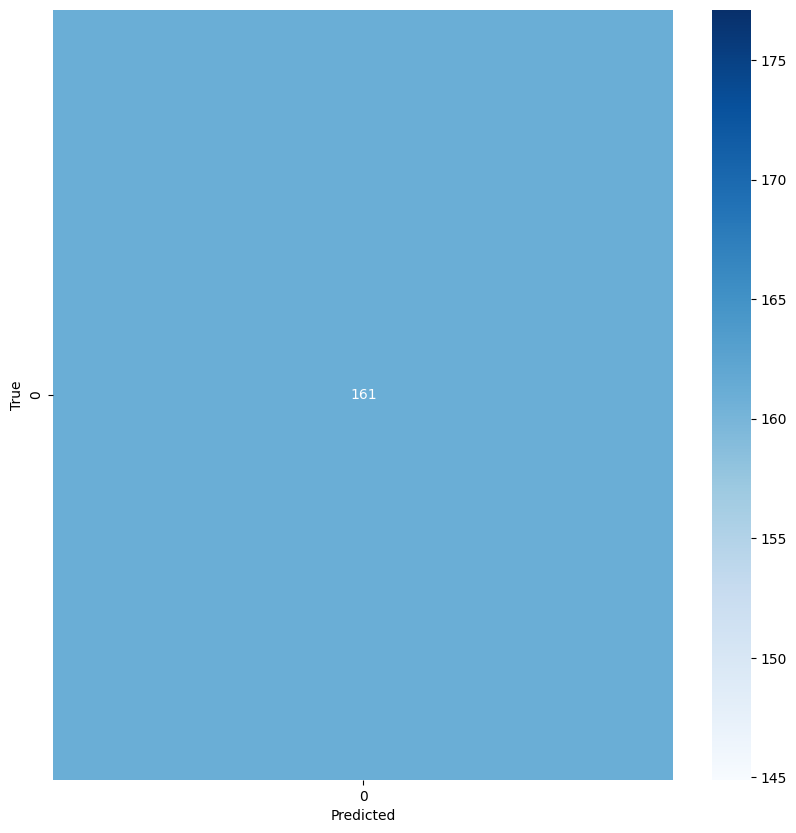

In [ ]:
from sklearn.metrics import confusion_matrix

# Evaluate the model
model.eval()

# These lists will keep track of all the true and predicted labels
all_labels = []
all_preds = []

running_loss = 0.0
running_corrects = 0

# In your training loop
for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Convert one-hot encoded labels back to integer format
    labels = torch.argmax(labels, dim=1)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

    # Store all labels and predictions
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

loss = running_loss / len(val_loader.dataset)
accuracy = running_corrects.double() / len(val_loader.dataset)

print('Val Loss: {:.4f} Acc: {:.4f}'.format(loss, accuracy))

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Log the loss and accuracy to wandb
wandb.log({"val_loss": loss, "val_acc": accuracy})

# Close the run
run.finish()

1. Data preprocessing

You need to define your own dataset class and load the data


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet

# Define transformations for the train set
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transformations for the validation/test set
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class XRayImageDataset(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        image = Image.open(img_name)
        label = img_name.split('/')[-2]

        if self.transform:
            image = self.transform(image)

        return image, label

# Get list of all image files
image_files = glob.glob('/content/xray_images/*/*.png')

# Split into train and validation sets
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Create datasets
train_data = XRayImageDataset(train_files, transform=train_transforms)
val_data = XRayImageDataset(val_files, transform=val_transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Load the EfficientNet-b0 model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Change the final layer to match the number of classes in the dataset
num_ftrs = model._fc.in_features
model._fc = torch.nn.Linear(num_ftrs, len(os.listdir('/content/xray_images')))

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


2. Model

Since we are using pytorch's implementation of the model, you don't need to design/implement the details of the model. You can simply load it with related functions, inclduing but not limited to optimizer

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn

# Load the EfficientNet-b0 model
model = EfficientNet.from_pretrained('efficientnet-b0')
model._dropout = nn.Dropout(0.2)
model._fc = nn.Linear(num_ftrs, num_classes)

# Change the final layer to match the number of classes in the dataset
num_ftrs = model._fc.in_features
num_classes = len(os.listdir('/content/xray_images'))
model._fc = nn.Linear(num_ftrs, num_classes)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the criterion with weights
weights = [0.5, 0.5] # Define your own weights here
class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


3. Training Loop

As indicated by the name, you need to write a loop to train the model. Don't forget to save the weights in case this session dies by accident

In [ ]:
# Number of epochs
num_epochs = 25

# Define early stopping
from pytorchtools import EarlyStopping
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = train_loader
        else:
            model.eval()   # Set model to evaluate mode
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            exp_lr_scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    print()

print('Training complete')

# Save the model weights
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/"

4. Result Report and Visulization

In this part, you want to evaluate the performance of the model: what's the loss, accuracy of the model? What about other performance metric?

You can further add Wandb, a training record monitoring add-on, to your loop so that you can easily visulize and share the result with others

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import wandb

# Function to display images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of validation data
inputs, classes = next(iter(val_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Evaluate the model
model.eval()

running_loss = 0.0
running_corrects = 0

# Iterate over data
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

loss = running_loss / len(val_loader.dataset)
accuracy = running_corrects.double() / len(val_loader.dataset)

print('Val Loss: {:.4f} Acc: {:.4f}'.format(loss, accuracy))

# Log the loss and accuracy to wandb
wandb.log({"val_loss": loss, "val_acc": accuracy})

# Close the run
run.finish()
